In [1]:
import numpy as np
import onnx
import os
import glob
import onnxruntime as rt
from onnxruntime import backend

from scipy.special import softmax
from PIL import Image
from onnx import numpy_helper

import IPython.display

In [2]:
# Downloaded from here: https://github.com/onnx/models/tree/master/vision/body_analysis/emotion_ferplus
model = onnx.load('../assets/emotion_ferplus/model.onnx')

In [16]:
emotion_table = {'neutral':0, 'happiness':1, 'surprise':2, 'sadness':3, 'anger':4, 'disgust':5, 'fear':6, 'contempt':7}

def preprocess(image_path):
    input_shape = (1, 1, 64, 64)
    img = Image.open(image_path)
    img = img.resize((64, 64), Image.ANTIALIAS).convert('L')
    img_data = np.array(img)
    img_data = np.resize(img_data, input_shape)
    return img_data.astype(np.float32)

def postprocess(scores):
    prob = softmax(scores)
    prob = np.squeeze(prob)
    classes = np.argsort(prob)[::-1]
    return classes

def to_classes(scores):
    prob = np.squeeze(softmax(scores))
    inverse_mapping = {v: k for k, v in emotion_table.items()}
    return {inverse_mapping[i]: prob for i, prob in enumerate(prob)}

def array_from_pb_image(path):
    tensor = onnx.TensorProto()
    with open(path, 'rb') as f:
        tensor.ParseFromString(f.read())
    return numpy_helper.to_array(tensor)
    
def pb_sample(data_dir):
    # Load inputs
    inputs = []
    inputs_num = len(glob.glob(os.path.join(test_data_dir, 'input_*.pb')))
    for i in range(inputs_num):
        input_file = os.path.join(test_data_dir, 'input_{}.pb'.format(i))
        inputs.append(array_from_pb_image(input_file))
        
    # Load reference outputs
    ref_outputs = []
    ref_outputs_num = len(glob.glob(os.path.join(test_data_dir, 'output_*.pb')))
    for i in range(ref_outputs_num):
        output_file = os.path.join(test_data_dir, 'output_{}.pb'.format(i))
        tensor = onnx.TensorProto()
        with open(output_file, 'rb') as f:
            tensor.ParseFromString(f.read())
        ref_outputs.append(numpy_helper.to_array(tensor))
        
    # Run the model on the backend
    outputs = list(backend.run(model, inputs))
    
    # Compare the results with reference outputs.
    for ref_o, o in zip(ref_outputs, outputs):
        np.testing.assert_almost_equal(ref_o, o, decimal=4)
    return outputs

def predict_classes_for_image(path):
    inputs = preprocess(path)
    outputs = list(backend.run(model, inputs))
    return to_classes(outputs)

In [4]:
test_data_dir = '../assets/emotion_ferplus/test_data_set_2'

outputs = pb_sample(test_data_dir)

Imagen: ../assets/images/happiness.jpg


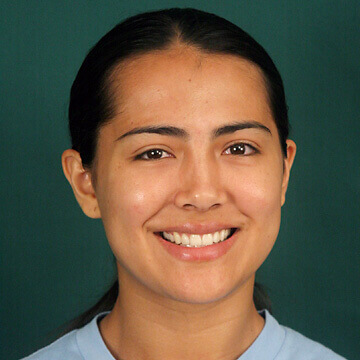

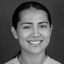

neutral 3.3807496e-06
happiness 0.99999523
surprise 1.2634276e-06
sadness 3.7209158e-09
anger 1.856849e-08
disgust 1.0785464e-09
fear 1.2438595e-09
contempt 5.1724506e-08
------------------------------------------------------------------------------------------------------------------------
Imagen: ../assets/images/disgust.jpg


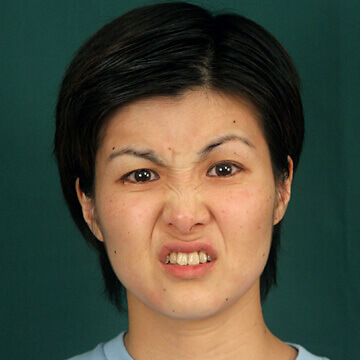

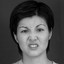

neutral 0.26354325
happiness 0.13716546
surprise 0.003020713
sadness 0.0051237997
anger 0.32476905
disgust 0.1867655
fear 0.0010148583
contempt 0.07859738
------------------------------------------------------------------------------------------------------------------------
Imagen: ../assets/images/surprise.jpg


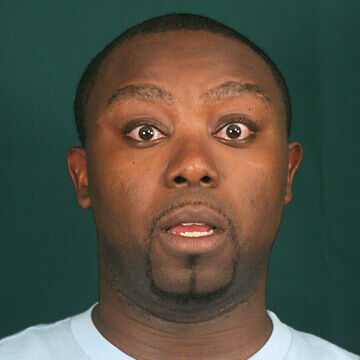

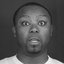

neutral 0.9842528
happiness 0.0012641003
surprise 0.009601565
sadness 0.00056205865
anger 0.0009808317
disgust 0.00013479717
fear 0.00012108034
contempt 0.003082673
------------------------------------------------------------------------------------------------------------------------
Imagen: ../assets/images/sadness.jpg


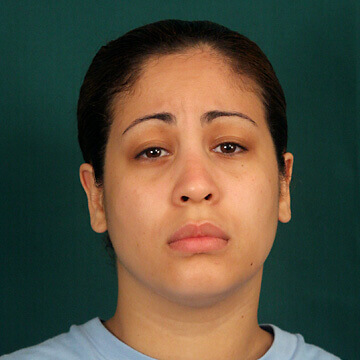

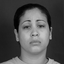

neutral 0.9684927
happiness 0.00095973344
surprise 0.00022006637
sadness 0.025489518
anger 0.00064803637
disgust 0.00013359035
fear 3.585629e-05
contempt 0.0040207077
------------------------------------------------------------------------------------------------------------------------
Imagen: ../assets/images/anger.jpg


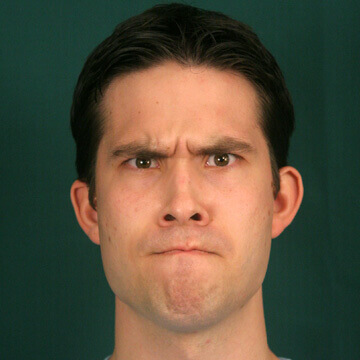

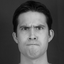

neutral 0.7008268
happiness 0.0033813012
surprise 0.0007020847
sadness 0.0051647495
anger 0.2502555
disgust 0.01881966
fear 0.000109248205
contempt 0.020740615
------------------------------------------------------------------------------------------------------------------------
Imagen: ../assets/images/fear.jpg


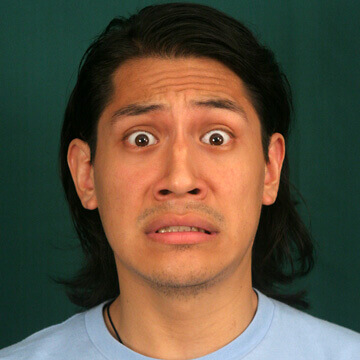

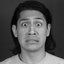

neutral 0.97678894
happiness 0.0064019556
surprise 0.008270051
sadness 0.002249442
anger 0.00045924186
disgust 0.00016047608
fear 0.00032723008
contempt 0.0053427457
------------------------------------------------------------------------------------------------------------------------
Imagen: ../assets/images/contempt.jpg


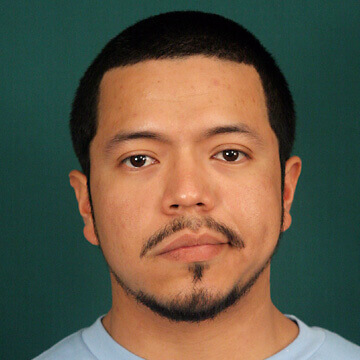

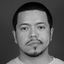

neutral 0.889086
happiness 0.10158262
surprise 0.00013387948
sadness 0.0011720136
anger 0.00011753497
disgust 6.106071e-05
fear 8.413663e-06
contempt 0.00783846
------------------------------------------------------------------------------------------------------------------------


In [6]:
# Los resultados se parecen a la demo en vivo https://microsoft.github.io/onnxjs-demo/#/emotion_ferplus
for image_path in glob.glob('../assets/images/*.jpg'):
    print('Imagen:', image_path)
    IPython.display.display(IPython.display.Image(image_path))
    inputs = preprocess(image_path)
    IPython.display.display(Image.fromarray(inputs[0][0].astype('uint8')))
    outputs = list(backend.run(model, inputs))
    for k, v in to_classes(outputs).items():
        print(k, v)
    print('---'*40)

In [7]:
image_array = array_from_pb_image('../assets/emotion_ferplus/test_data_set_1/input_0.pb')

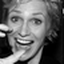

In [8]:
Image.fromarray(image_array[0][0].astype('uint8'))

In [9]:
outputs = list(backend.run(model, [image_array]))

In [10]:
to_classes(outputs)

{'neutral': 0.000100657984,
 'happiness': 0.9455971,
 'surprise': 0.05414596,
 'sadness': 8.7375804e-07,
 'anger': 3.2292013e-05,
 'disgust': 1.0345464e-06,
 'fear': 0.00011944669,
 'contempt': 2.609734e-06}

In [11]:
image_array = array_from_pb_image('../assets/emotion_ferplus/test_data_set_0/input_0.pb')

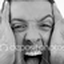

In [9]:
Image.fromarray(image_array[0][0].astype('uint8'))

In [10]:
outputs = list(backend.run(model, [image_array]))
to_classes(outputs)

{'neutral': 0.3590992,
 'happiness': 0.06076562,
 'surprise': 0.0256614,
 'sadness': 0.063011825,
 'anger': 0.42557934,
 'disgust': 0.0415218,
 'fear': 0.006898141,
 'contempt': 0.017462576}

In [191]:
#img = Image.open('~/Downloads/happy_woman.png')

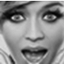

In [192]:
img.resize((64, 64), Image.ANTIALIAS)

In [12]:
inputs = preprocess('../assets/images/happiness.jpg')

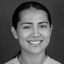

In [13]:
Image.fromarray(inputs[0][0].astype('uint8'))

In [14]:
outputs = list(backend.run(model, inputs))

In [18]:
to_classes(outputs)

{'neutral': 3.3807496e-06,
 'happiness': 0.99999523,
 'surprise': 1.2634276e-06,
 'sadness': 3.7209158e-09,
 'anger': 1.856849e-08,
 'disgust': 1.0785464e-09,
 'fear': 1.2438595e-09,
 'contempt': 5.1724506e-08}

In [24]:
import io

In [20]:
with open('../assets/images/happiness.jpg', 'rb') as f:
    bytes_data = f.read()

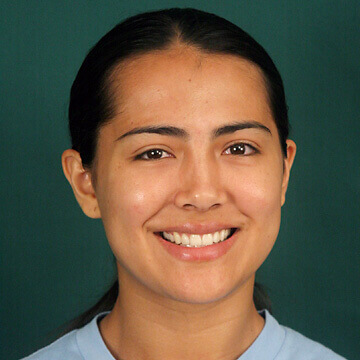

In [27]:
Image.open(io.BytesIO(bytes_data))

In [205]:
# TODO: Crop face with opencv: https://realpython.com/face-recognition-with-python/
import cv2